In [29]:
import pandas as pd
import numpy as np
import h5py
from datetime import datetime, timedelta
import sys

from matplotlib.colors import TwoSlopeNorm, LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import geopandas as gpd

In [30]:
folder_path = "../"
sys.path.append(folder_path)
sys.path.append("../mobility_function/")
from mobility_function import analysis as ma
from importlib import reload
import mobility_function.analysis as ma
import mobility_function.hurricane_plotting as mhp
ma = reload(ma)
mhp = reload(mhp)

In [31]:
ymd_ofweek = np.load('ymd_ofweek.npy').tolist()
start_idx = ymd_ofweek.index('2023-09-11')
comparable_weeks = ymd_ofweek[start_idx:start_idx+8]
len(comparable_weeks)

8

In [32]:
# Ms_h_base = ma.h5py_to_4d_array(f'../data/mobility/M_raw_20230911.h5')

### get the average visits value for the 2 months before
all_matrices = []
for i, wk in enumerate(comparable_weeks):
    print (wk)
    wk_i = datetime.strptime(wk, "%Y-%m-%d").strftime("%Y%m%d")
    Ms_wk_i = ma.h5py_to_4d_array(f'../data/mobility/M_raw_{wk_i}.h5')
    all_matrices.append(Ms_wk_i) 
Ms_wks_stacked = np.stack(all_matrices, axis=0)

2023-09-11
2023-09-18
2023-09-25
2023-10-02
2023-10-09
2023-10-16
2023-10-23
2023-10-30


In [33]:
Ms_h_base = np.mean(Ms_wks_stacked, axis=0)
print(Ms_h_base.shape)

(7, 17, 3144, 3144)


In [34]:
# np.save('Ms_h_base.npy', Ms_h_base)

In [35]:
def get_wk_visits_region_dst(Ms_x,selected_idx, dst_idx):
    M_regout_x = ma.region_out_desitination(Ms_x, selected_idx)
    # (7, 271, 3144) shape
    M_region_x_out_hwk_sum = np.sum(M_regout_x,axis=0) # sum up the 7 days
    M_region_x_dst_hwk_sum = M_region_x_out_hwk_sum[:,dst_idx] # select the destination counties
    region_x_dst_hwk_sum = np.sum(M_region_x_dst_hwk_sum,axis=0) # sum up the regions counties
    return region_x_dst_hwk_sum

In [36]:
def get_wk_visits_change(hrc_name, Ms_h_base, Ms_wks_stacked):
    # hrc_name = 'x'
    cutoff_mile = 50
    print(cutoff_mile)
    with open("../results/{}/counties_geoid_cut_{}.txt".format(hrc_name,cutoff_mile), "r") as f:
        county_list = [line.strip() for line in f]

    county_list = [int(x) for x in county_list]
    geo_idx = pd.read_csv('geoid_idx_names.csv')
    selected_idx = geo_idx[geo_idx['GEOID'].isin(county_list)].county_idx.values

    print('no of selected counties',len(selected_idx))
    selected_names = geo_idx[geo_idx['GEOID'].isin(county_list)].NAME.values
    ### destination index
    with open("../results/{}/dest_counties_geoid_{}.txt".format(hrc_name, cutoff_mile), "r") as f:
        dst_county_list = [line.strip() for line in f]
    dst_county_list = [int(x) for x in dst_county_list]
    print('no of destination county',len(dst_county_list))
    dst_idx = geo_idx[geo_idx['GEOID'].isin(dst_county_list)].county_idx.values

    dst_names = geo_idx[geo_idx['GEOID'].isin(dst_county_list)].NAME.values
    rg_names = geo_idx[geo_idx['GEOID'].isin(county_list)].NAME.values

    len_dst = len(dst_names)
    len_rg = len(rg_names)

    region_base_dst = get_wk_visits_region_dst(Ms_h_base,selected_idx, dst_idx)

    M_change_wks = np.zeros((len(comparable_weeks), len_dst))
    for wk_idx in range(len(comparable_weeks)):
        region_wki_dst = get_wk_visits_region_dst(Ms_wks_stacked[wk_idx],selected_idx, dst_idx)
        change_wki = (region_wki_dst - region_base_dst)/region_base_dst
        M_change_wks[wk_idx] = change_wki

    mean_change_wks = np.mean(M_change_wks, axis=0)
    selected_idx = geo_idx[geo_idx['GEOID'].isin(county_list)].county_idx.values
    return mean_change_wks, selected_idx, dst_idx

In [37]:
mean_change_wks_milton, selected_idx_m, dst_idx_m = get_wk_visits_change('milton', Ms_h_base, Ms_wks_stacked)
mean_change_wks_helene, selected_idx_h, dst_idx_h = get_wk_visits_change('helene', Ms_h_base, Ms_wks_stacked)  

# M_change_wks_milton, selected_idx_m, dst_idx_m = get_wk_visits_change('milton', Ms_h_base, Ms_wks_stacked)
# M_change_wks_helene, selected_idx_h, dst_idx_h = get_wk_visits_change('helene', Ms_h_base, Ms_wks_stacked)  

50
no of selected counties 21
no of destination county 310
50
no of selected counties 271
no of destination county 230


In [38]:
def bar_plot_data(mean_change_wks):
        my_bins = np.concatenate([np.linspace(-2, 2, 25), [30]])
        x_hist, x_edges = np.histogram(mean_change_wks, bins=my_bins, density=False)
        wd_h = np.diff(x_edges)
        wd_h[-1] = wd_h[0]

        x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
        x_bin_centers[-1] = x_bin_centers[-2] + wd_h[0]


        x_hist_density = x_hist / (sum(x_hist))
        return x_hist_density, x_bin_centers, wd_h

In [39]:
# milton_hist_density, milton_bin_centers, wd_m = bar_plot_data(M_change_wks_milton.ravel())
# helene_hist_density, helene_bin_centers, wd_h = bar_plot_data(M_change_wks_helene.ravel())

In [40]:
# fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.8), dpi=300)
# ax.bar(milton_bin_centers, milton_hist_density, width=wd_m, align='center', 
#         label='Milton', alpha=0.7, color='mediumpurple')
# ax.bar(helene_bin_centers, helene_hist_density, width=wd_h, align='center', 
#         label='Helene', alpha=0.7, color='yellowgreen')
# xticks = [-1, 0.0, 1, 2.08333333]  # Custom tick positions
# xtick_labels = ['-100%', '0.0', '100%', '>200%']  # Corresponding labels
# # ax.set_xlim(-0.11*100_000,0.11*100_000)
# # # ax.set_ylim(0.7,210)
# ax.set_xticks(xticks)
# ax.set_xticklabels(xtick_labels, fontsize=6)
# ax.tick_params(axis='y', labelsize=6)

# # Customizations
# ax.legend(frameon=False, fontsize=6)
# ax.axvline(0, color='black', linestyle='--', lw=0.5)
# # ax.set_xlabel('Change in number of visits per 100K population', size=6)
# ax.set_xlabel('Relative changes in visit to one dest. county',size=6)
# ax.set_ylabel('Probability', size=6)
# # ax.set_yscale('log')
# # ax.set_title(f'{p_name}', size=6)

In [41]:
geo_idx = pd.read_csv('geoid_idx_names.csv')

In [42]:
def get_out_region_fluactions_ts(hrc_name,Ms_h_base,):
    # hrc_name = 'helene'
    cutoff_mile = 50
    print(cutoff_mile, hrc_name)
    ### region ids
    with open("../results/{}/counties_geoid_cut_{}.txt".format(hrc_name,cutoff_mile), "r") as f:
        county_list = [line.strip() for line in f]

    county_list = [int(x) for x in county_list]
    selected_idx = geo_idx[geo_idx['GEOID'].isin(county_list)].county_idx.values

    ### get the regions base visits
    M_regout_base = ma.region_out_desitination(Ms_h_base, selected_idx)
    V_regout_all_base = np.sum(M_regout_base, axis=1)
    regout_all_base = np.sum(V_regout_all_base, axis=1)
    ts_regout_all = np.zeros((len(comparable_weeks), 7))
    
    for i, wk in enumerate(comparable_weeks):
        print (wk)
        wk_i = datetime.strptime(wk, "%Y-%m-%d").strftime("%Y%m%d")
        Ms_wk_i = ma.h5py_to_4d_array(f'../data/mobility/M_raw_{wk_i}.h5')
        M_regout_i = ma.region_out_desitination(Ms_wk_i, selected_idx)
        V_regout_all_i = np.sum(M_regout_i, axis=1)
        regout_all_i = np.sum(V_regout_all_i, axis=1)
        # plt.plot(regout_all_i)
        ts_regout_all[i] = regout_all_i
        with np.errstate(divide='ignore', invalid='ignore'):
            fluctuation_percentages = np.where(
                regout_all_base == 0,
                0,  # or np.nan if preferred
                (regout_all_i - regout_all_base) / regout_all_base
            )
        if i == 0:
            M_fluctuation = fluctuation_percentages
        else:
            M_fluctuation = np.concatenate([M_fluctuation, fluctuation_percentages], axis=0)
    return M_fluctuation, ts_regout_all

In [43]:
ts_fluctuation_milton, ts_regout_all_milton = get_out_region_fluactions_ts('milton', Ms_h_base)
ts_fluctuation_helene, ts_regout_all_helene = get_out_region_fluactions_ts('helene', Ms_h_base)

50 milton
2023-09-11
2023-09-18
2023-09-25
2023-10-02
2023-10-09
2023-10-16
2023-10-23
2023-10-30
50 helene
2023-09-11
2023-09-18
2023-09-25
2023-10-02
2023-10-09
2023-10-16
2023-10-23
2023-10-30


In [44]:
from scipy.stats import gaussian_kde
def find_distribution(data):
    kde = gaussian_kde(data, bw_method='scott')  # or 'silverman', or a float like 0.2
    # Create a range of x values over which to evaluate KDE
    x_vals = np.linspace(min(data) - 1, max(data) + 1, 1000)
    pdf_vals = kde(x_vals)

    # Compute CDF from PDF
    cdf_vals = np.cumsum(pdf_vals)
    cdf_vals /= cdf_vals[-1]  # normalize

    # Find 2.5% and 97.5% thresholds
    x_025 = x_vals[np.searchsorted(cdf_vals, 0.025)]
    x_975 = x_vals[np.searchsorted(cdf_vals, 0.975)]
    bin_edges = np.linspace(-0.15, 0.15, 20)
    bins, _ = np.histogram(data, bin_edges, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = np.diff(bin_edges)[0]
    return pdf_vals, x_vals, x_025, x_975, bins, bin_centers, bin_width

In [45]:
pdf_vals_milton, x_vals_milton, x_025_milton, x_975_milton, bins_milton, bin_centers_milton, bin_width_milton = find_distribution(ts_fluctuation_milton)
pdf_vals_helene, x_vals_helene, x_025_helene, x_975_helene, bins_helene, bin_centers_helene, bin_width_helene = find_distribution(ts_fluctuation_helene)

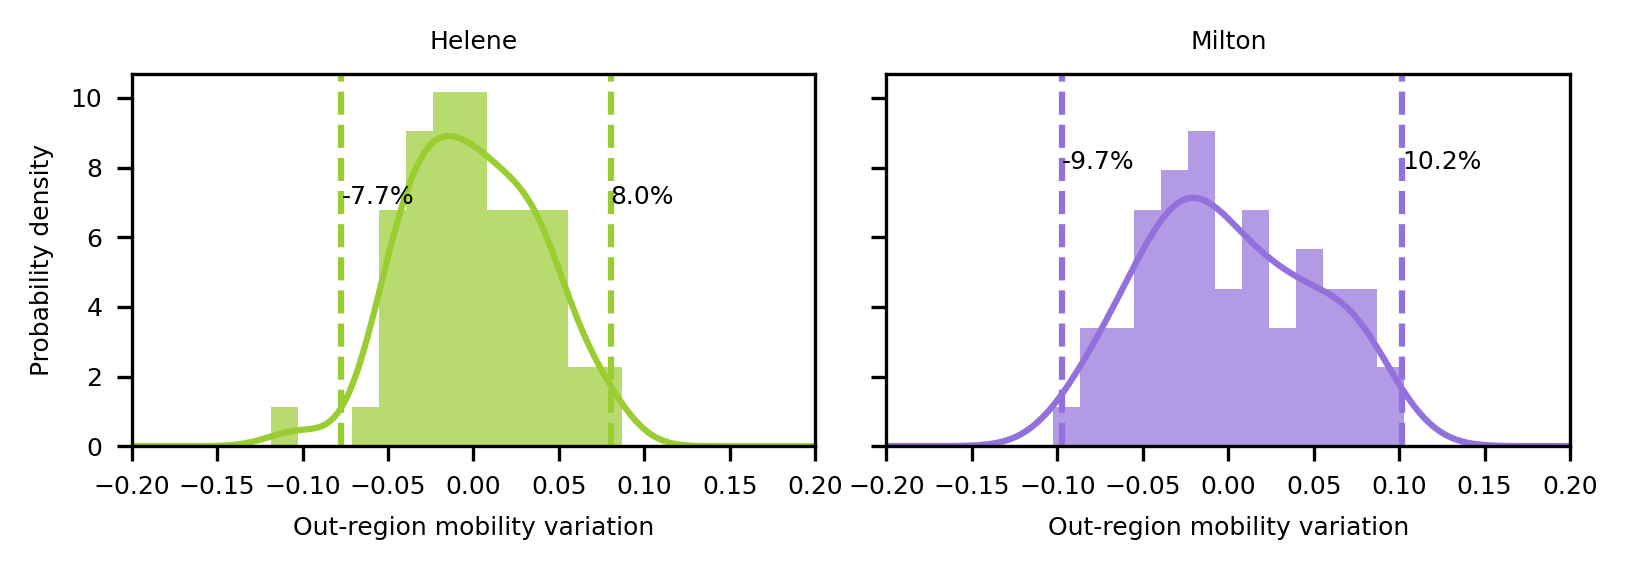

In [46]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.), dpi=300, sharey=True)
#### helene
axs[0].bar(bin_centers_helene, bins_helene, alpha=0.7, label='Helene', color='yellowgreen', width=bin_width_helene)
axs[0].plot(x_vals_helene, pdf_vals_helene, color='yellowgreen')
axs[0].axvline(x_025_helene, color='yellowgreen', linestyle='--')
axs[0].axvline(x_975_helene, color='yellowgreen', linestyle='--')
axs[0].text(x_025_helene, 7.5, f'{x_025_helene * 100:.1f}%', color='black', fontsize=6,
            ha='left', va='top', bbox=dict(facecolor='none', alpha=1, edgecolor='none'))
axs[0].text(x_975_helene, 7.5, f'{x_975_helene * 100:.1f}%', color='black', fontsize=6,
            ha='left', va='top', bbox=dict(facecolor='none', alpha=1, edgecolor='none'))
axs[0].set_xlim(-0.2, 0.2)
axs[0].set_xlabel('Out-region mobility variation', fontsize=6)
axs[0].tick_params(axis='both', labelsize=6)
axs[0].set_title('Helene', fontsize=6)
axs[0].set_ylabel('Probability density', fontsize=6)
### milton
axs[1].bar(bin_centers_milton, bins_milton, alpha=0.7, label='Milton', color='mediumpurple', width=bin_width_milton)
axs[1].plot(x_vals_milton, pdf_vals_milton, color='mediumpurple')
axs[1].axvline(x_025_milton, color='mediumpurple', linestyle='--')
axs[1].axvline(x_975_milton, color='mediumpurple', linestyle='--')
axs[1].text(x_025_milton, 8.5, f'{x_025_milton * 100:.1f}%', color='black', fontsize=6,
            ha='left', va='top', bbox=dict(facecolor='none', alpha=1, edgecolor='none'))
axs[1].text(x_975_milton, 8.5, f'{x_975_milton * 100:.1f}%', color='black', fontsize=6,
            ha='left', va='top', bbox=dict(facecolor='none', alpha=1, edgecolor='none'))
axs[1].set_xlim(-0.2, 0.2)
axs[1].set_xlabel('Out-region mobility variation', fontsize=6)
axs[1].tick_params(axis='both', labelsize=6)
axs[1].set_title('Milton', fontsize=6)



plt.tight_layout(w_pad=0.5)
plt.savefig(f'../results/baseline_distribution_out_region.png', format = 'png',dpi=450,bbox_inches='tight',transparent=True)